# Analyze an A/B test from the popular mobile puzzle game, Cookie Cats.

# About

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. Check out this short demo:

<a href="https://www.youtube.com/watch?v=GaP5f0jVTWE&ab_channel=TactileGames">
    <img alt="video" src="img/cookie_cats_video.jpeg"
    width=50% height=50%>
</a>

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

<img src="img/cc_gates.png" width=60% height=60% align=center>


But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.

## Data
The DataFrame contains 90189 rows, each representing a user session.
We also have 5 columns:

* `userid`:  A unique number that identifies each player.
* `version` : Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40)
* `sum_gamerounds` : The number of game rounds played by the player during the first 14 days after install.
* `retention_1` : Did the player come back and play 1 day after installing?
* `retention_7` : Did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either `gate_30` or `gate_40`. As a sanity check, let's see if there are roughly the same number of players in each AB group.

<img src="img/df.png" width=60% height=60% align=center>



## Pipeline
* Understanding the Data
* Normality Test
* Remove Outliers
* Testing `retention_1`
* Testing `retention_7`
* Testing `sum_gamerounds`
* Conclusion

# Understanding Data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import sem, zscore
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from numpy import std, mean, sqrt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [12]:
dataset = pd.read_csv('cookie_cats.csv')
dataset

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [14]:
print(dataset['userid'].duplicated().sum()) 
print("there is no user that would have played on both versions")

0
there is no user that would have played on both versions


In [15]:
display(dataset['version'].value_counts())
print('-----')
print('There are roughly as many users on both versions which is a good thing for our analysis')

gate_40    45489
gate_30    44700
Name: version, dtype: int64

-----
There are roughly as many users on both versions which is a good thing for our analysis


In [16]:
sum_gamerounds = dataset.groupby('version')['sum_gamerounds'].agg([np.mean, std ,sem, np.min, np.max])
sum_gamerounds.columns = ['mean', 'std', 'standard error of the mean', 'min', 'max']
display(sum_gamerounds.style.format('{:.3f}'))
print('The sum_gamerounds looks slightly higher for the version gate 30, however we did not check for outliers yet')

retention1 = dataset.groupby('version')['retention_1'].agg([np.mean, std ,sem])
retention1.columns = ['mean', 'std', 'standard error of the mean']
display(retention1.style.format('{:.3f}'))
print('The retention looks slightly higher for the version gate 30, however we did not check for outliers yet')

retention7 = dataset.groupby('version')['retention_7'].agg([np.mean, std ,sem])
retention7.columns = ['mean', 'std', 'standard error of the mean']
display(retention7.style.format('{:.3f}'))
print('Same conclusion here')

,mean,std,standard error of the mean,min,max
version,,,,,
gate_30,52.456,256.716,1.214,0.000,49854.000
gate_40,51.299,103.294,0.484,0.000,2640.000


The sum_gamerounds looks slightly higher for the version gate 30, however we did not check for outliers yet


,mean,std,standard error of the mean
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


The retention looks slightly higher for the version gate 30, however we did not check for outliers yet


,mean,std,standard error of the mean
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


Same conclusion here


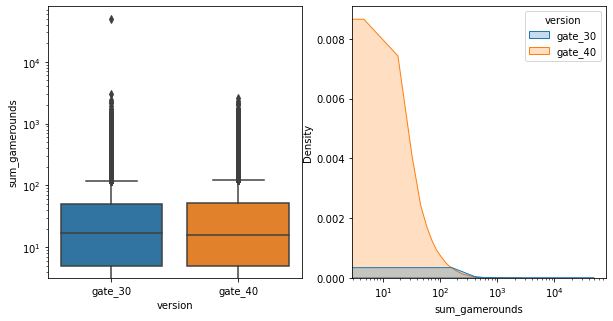

There's an outlier with a very high value on the gate_30 group which makes us use the log scale in order to see something
A part from that, the distributions look very similar at the first glance


In [17]:
fig, ax = plt.subplots(1,2,figsize=(10,5) )
sns.boxplot(data = dataset, x = 'version', y = 'sum_gamerounds', ax = ax[0])
sns.kdeplot(data = dataset, x= 'sum_gamerounds', hue='version', shade = True,ax = ax[1])
ax[0].set_yscale('log')
ax[1].set_xscale('log')
plt.show()
print("There's an outlier with a very high value on the gate_30 group which makes us use the log scale in order to see something")
print('A part from that, the distributions look very similar at the first glance')

In [19]:
verbatim = '''
There are many way to remove outliers, generally we use the zscore method but to make it work the data has to follow a normal distribution. Is it the case ?
'''
print(verbatim)


There are many way to remove outliers, generally we use the zscore method but to make it work the data has to follow a normal distribution. Is it the case ?



# Normality Test

## Quantile Quantile Plot

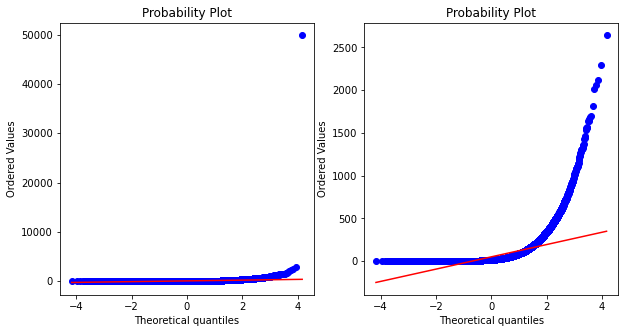

it doesn't look normal


In [37]:
A = dataset[dataset['version'] == "gate_30"]['sum_gamerounds']
B = dataset[dataset['version'] == "gate_40"]['sum_gamerounds']

fig, ax = plt.subplots(1,2, figsize=(10,5))
stats.probplot(A, plot=ax[0])
stats.probplot(B, plot=ax[1])
plt.show()
print("it doesn't look normal")

## D’Agostino and Pearson’s Test

In [42]:
_, pvalue1 = stats.normaltest(A)
_, pvalue2 = stats.normaltest(B)
pvalue1, pvalue2
print('Null hypothesis : Distribution is Normal')
print("pvalues < alpha so the null hypothesis can be rejected, the data doesn't come from a normal distribution")

Null hypothesis : Distribution is Normal
pvalues < alpha so the null hypothesis can be rejected, the data doesn't come from a normal distribution


# Removing Outliers

In [43]:
def remove_outliers(df, col_name):
    before = len(df)
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (df[col_name] >= Q1 - 1.5 * IQR) & (df[col_name] <= Q3 + 1.5 *IQR)
    new_df = df.loc[filter]  
    after = (len(new_df))
    print(before-after,'lines were removed')
    return new_df




In [44]:
print('We decide to remove outliers with the boxplot definition as the data does not seem to follow a normal distribution')


We decide to remove outliers with the boxplot definition as the data does not seem to follow a normal distribution


In [45]:
df_gate_30 = dataset.loc[dataset['version']=='gate_30']
df_gate_40 = dataset.loc[dataset['version']=='gate_40']

#remove outliers
df_gate_30 = remove_outliers(df_gate_30, 'sum_gamerounds')
df_gate_40 = remove_outliers(df_gate_40, 'sum_gamerounds')

#creating a new df
new_df = pd.concat([df_gate_30, df_gate_40], axis = 0)

5207 lines were removed
5018 lines were removed


In [46]:
new_df['version'].value_counts()

gate_40    40471
gate_30    39493
Name: version, dtype: int64

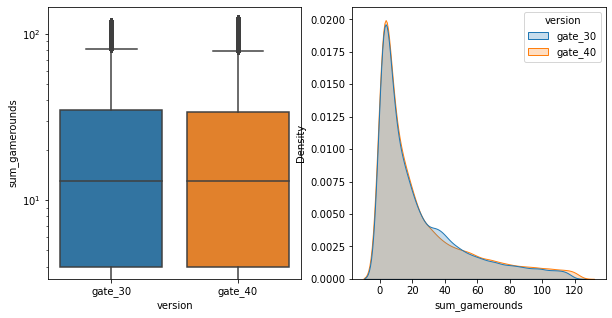

Here is what the distributions look like after removing outliers


In [47]:
fig, ax = plt.subplots(1,2,figsize=(10,5) )
sns.boxplot(data = new_df, x = 'version', y = 'sum_gamerounds', ax = ax[0])
sns.kdeplot(data = new_df, x= 'sum_gamerounds', hue='version', shade = True,ax = ax[1])
ax[0].set_yscale('log')
plt.show()
print('Here is what the distributions look like after removing outliers')

In [48]:
sum_gamerounds = new_df.groupby('version')['sum_gamerounds'].agg([np.mean, std ,sem, np.min, np.max])
sum_gamerounds.columns = ['mean', 'std', 'standard error of the mean', 'min', 'max']
display(sum_gamerounds.style.format('{:.3f}'))
print('After removing outliers it seems that the gate_40 version does have an edge on the gate_30 version on the sum_gamerounds department')
print('also the mean seems to have less variability for the gate_30 version')

retention1 = new_df.groupby('version')['retention_1'].agg([np.mean, std ,sem])
retention1.columns = ['mean', 'std', 'standard error of the mean']
display(retention1.style.format('{:.3f}'))
print('After removing outliers retention_1 looks better on the gate_30 version, is it significant ?')

retention7 = new_df.groupby('version')['retention_7'].agg([np.mean, std ,sem])
retention7.columns = ['mean', 'std', 'standard error of the mean']
display(retention7.style.format('{:.3f}'))
print('After removing outliers retention_7 looks better on the gate_30 version, is it significant ?')

,mean,std,standard error of the mean,min,max
version,,,,,
gate_30,23.597,26.585,0.134,0.000,117.000
gate_40,24.246,28.173,0.140,0.000,122.000


After removing outliers it seems that the gate_40 version does have an edge on the gate_30 version on the sum_gamerounds department
also the mean seems to have less variability for the gate_30 version


,mean,std,standard error of the mean
version,,,
gate_30,0.387,0.487,0.002
gate_40,0.384,0.486,0.002


After removing outliers retention_1 looks better on the gate_30 version, is it significant ?


,mean,std,standard error of the mean
version,,,
gate_30,0.117,0.321,0.002
gate_40,0.111,0.314,0.002


After removing outliers retention_7 looks better on the gate_30 version, is it significant ?


# Hypothesis Testing

* Null Hypothesis - H0: means are the same on both version
* Alternative Hypothesis - H1 : means are different
* We want a two-sided test
* Thresold α: 0.05

In [50]:
alpha = 0.05

## 1 - Testing `sum_gamerounds`

In [51]:
#The central limit theorem ensured that the distribution of the mean is normally distributed
#and the samples we use are way higher than n = 30
#So we can use the T-test

from statsmodels.stats.weightstats import ttest_ind
tstat, pvalue, ddf = ttest_ind(
    df_gate_40['sum_gamerounds'], df_gate_30['sum_gamerounds'],
    alternative='two-sided',
    usevar='pooled',
    weights=(None, None), value=0
    )

print('tstat = ',round(tstat,2))
print('pvalue < alpha : ', pvalue < alpha, ', so we fail to reject the null hypothesis')
print('which means that there is statistical significance of sum_gamerounds mean being higher on the gate_40 version')

tstat =  3.35
pvalue < alpha :  True , so we fail to reject the null hypothesis
which means that there is statistical significance of sum_gamerounds mean being higher on the gate_40 version


## 2 - Testing `retention_1`

In [80]:
col_to_test = 'retention_1'
count = np.array([df_gate_40[col_to_test].sum(), df_gate_30[col_to_test].sum()])
nobs = np.array([df_gate_40[col_to_test].count(), df_gate_30[col_to_test].count()])
stat, pval = proportions_ztest(count, nobs, alternative = 'two-sided')
print('{0:0.3f}'.format(pval))
print('pval<alpha :',pval < alpha)
print("We cannot reject H0: there is no statistical significance of a difference in retention_1 between the two versions")

0.382
pval<alpha : False
We cannot reject H0: there is no statistical significance of a difference in retention_1 between the two versions


## 3 - Testing `retention_7`

In [84]:
col_to_test = 'retention_7'
count = np.array([df_gate_40[col_to_test].sum(), df_gate_30[col_to_test].sum()])
nobs = np.array([df_gate_40[col_to_test].count(), df_gate_30[col_to_test].count()])
stat, pval = proportions_ztest(count, nobs, alternative='two-sided')
print('{0:0.3f}'.format(pval))
print('pval<alpha :',pval < alpha)
print('there is statistical significance, retention_7 is higher in version gate 30')

0.011
pval<alpha : True
there is statistical significance, retention_7 is higher in version gate 30


# Conclusion

The result tell us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40 while 1-day retention remains more or less the same. On the mean time, `sum_gamerounds` is slightly higher on the version gate_40. We have to wonder what is better on a business point of view: better retention on the long term or a higher `sum_gamerounds`. Either way, if we want to keep retention high — we should not move the gate from level 30 to level 40. 